In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications import imagenet_utils
from keras.applications import vgg16
from keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.models import Model
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
train_path  = 'dataset/train'
valid_path  = 'dataset/valid'
test_path  = 'dataset/test'
train_batches = ImageDataGenerator().flow_from_directory(train_path,
                                                         target_size=(224,224),
                                                         batch_size=10)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path,
                                                         target_size=(224,224),
                                                         batch_size=30)
test_batches = ImageDataGenerator().flow_from_directory(test_path,
                                                        target_size=(224,224),
                                                        batch_size=50,
                                                        shuffle=False)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [4]:
base_model = vgg16.VGG16(weights = "imagenet", include_top=False,
                         input_shape = (224,224, 3), pooling='avg')
for layer in base_model.layers[:-5]:
    layer.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [5]:
last_output = base_model.output
x = Dense(10, activation='softmax', name='softmax')(last_output)
new_model = Model(inputs=base_model.input, outputs=x)
new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [6]:
new_model.compile(Adam(lr=0.0001), loss='categorical_crossentropy',
                  metrics=['accuracy'])
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='signlanguage.model.hdf5',
                               save_best_only=True)
history = new_model.fit_generator(train_batches, steps_per_epoch=18,
                   validation_data=valid_batches, validation_steps=3,
                   epochs=20, verbose=1, callbacks=[checkpointer])

C:\Users\darsh\anaconda3\envs\DLVS\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
18/18 [==============================] - 46s 3s/step - loss: 4.3583 - accuracy: 0.2005 - val_loss: 1.8030 - val_accuracy: 0.4111

In [7]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np

def load_dataset(path):
    data = load_files(path)
    paths = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']))
    return paths, targets

test_files, test_targets = load_dataset('dataset/test')
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from tqdm import tqdm

def path_to_tensor(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

test_tensors = preprocess_input(paths_to_tensor(test_files))
print('\nTesting loss: {:.4f}\nTesting accuracy: {:.4f}'.format(*new_model.evaluate(test_tensors, test_targets)))

100%|██████████| 50/50 [00:00<00:00, 442.50it/s]


2/2 [==============================] - 7s 2s/step - loss: 0.1950 - accuracy: 0.9200

Testing loss: 0.1950
Testing accuracy: 0.9200


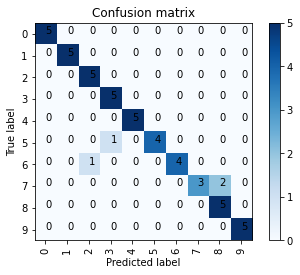

In [8]:
from sklearn.metrics import confusion_matrix
import numpy as np

cm_labels = ['0','1','2','3','4','5','6','7','8','9']

cm = confusion_matrix(np.argmax(test_targets, axis=1),
                      np.argmax(new_model.predict(test_tensors), axis=1))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
indexes = np.arange(len(cm_labels))
for i in indexes:
    for j in indexes:
        plt.text(j, i, cm[i, j])
plt.xticks(indexes, cm_labels, rotation=90)
plt.xlabel('Predicted label')
plt.yticks(indexes, cm_labels)
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()